# Utilisation des Handoffs

In [1]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv())

llm_model = "gpt-4o-mini"

In [2]:
from agents import Agent, handoff

billing_agent = Agent(name="Billing agent", model=llm_model)
refund_agent = Agent(name="Refund agent", model=llm_model)


triage_agent = Agent(name="Triage agent", model=llm_model,handoffs=[billing_agent, handoff(refund_agent)])

In [3]:
from agents import Runner

result = await Runner.run(triage_agent, "I want a refund for my last purchase")

In [4]:
print(result)

RunResult:
- Last agent: Agent(name="Refund agent", ...)
- Final output (str):
    I've connected you to a refund agent who can assist you with your request. Please provide them with the details of your purchase.
- 3 new item(s)
- 2 raw response(s)
- 0 input guardrail result(s)
- 0 output guardrail result(s)
(See `RunResult` for more details)


In [5]:
print(result.new_items[0])

HandoffCallItem(agent=Agent(name='Triage agent', instructions=None, handoff_description=None, handoffs=[Agent(name='Billing agent', instructions=None, handoff_description=None, handoffs=[], model='gpt-4o-mini', model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True), Handoff(tool_name='transfer_to_refund_agent', tool_description='Handoff to the Refund agent agent to handle the request. ', input_json_schema={'additionalProperties': False, 'type': 'object', 'properties': {}, 'required': []}, on_invoke_handoff=<function handoff.<locals>._invoke_handoff at 0x000001652A645BC0>, 

Pour visualiser le graph d'appel, il est nécessaire d'installer GraphViz

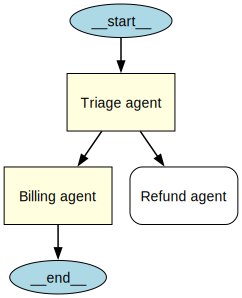

In [6]:
from agents.extensions.visualization import draw_graph
draw_graph(triage_agent)

In [7]:
from pydantic import BaseModel

from agents import Agent, handoff, RunContextWrapper

class EscalationData(BaseModel):
    reason: str

async def on_handoff(ctx: RunContextWrapper[None], input_data: EscalationData):
    print(f"Escalation agent called with reason: {input_data.reason}")

agent = Agent(name="Escalation agent")

handoff_obj = handoff(
    agent=agent,
    on_handoff=on_handoff,
    input_type=EscalationData,
)

In [8]:
triage_agent.handoffs.append(handoff_obj)

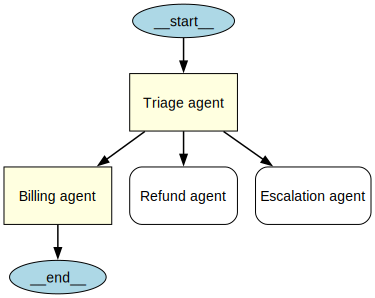

In [9]:
draw_graph(triage_agent)

In [10]:
result = await Runner.run(triage_agent, "I want to escalate my issue because I am not satisfied with the refund process")

Escalation agent called with reason: Not satisfied with the refund process


In [12]:
print(result.last_agent)

Agent(name='Escalation agent', instructions=None, handoff_description=None, handoffs=[], model=None, model_settings=ModelSettings(temperature=None, top_p=None, frequency_penalty=None, presence_penalty=None, tool_choice=None, parallel_tool_calls=None, truncation=None, max_tokens=None, reasoning=None, metadata=None, store=None, include_usage=None, extra_query=None, extra_body=None, extra_headers=None), tools=[], mcp_servers=[], mcp_config={}, input_guardrails=[], output_guardrails=[], output_type=None, hooks=None, tool_use_behavior='run_llm_again', reset_tool_choice=True)


In [ ]:
from agents.extensions.handoff_prompt import prompt_with_handoff_instructions 

handoff_obj.agent(
    name = "Escalation agent",
    instructions=prompt_with_handoff_instructions("Answer politely and provide a solution to the customer's issue.")
)